In [3]:

import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(0)

from tqdm.notebook import trange

import random

Definiton Reversi

In [60]:
def parse_map_file(filepath, max_players):
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = [line.strip() for line in f if line.strip()]
    
    player_count = int(lines[0])
    if player_count > max_players:
        raise ValueError(f"Maximal {max_players} Spieler erlaubt, aber {player_count} gefunden.")

    height, width = map(int, lines[3].split())
    raw_map_lines = lines[4:]
    
    if len(raw_map_lines) != height:
        raise ValueError(f"Erwartet {height} Zeilen, aber {len(raw_map_lines)} Zeilen in Map gefunden.")

    flat_map = []
    for line in raw_map_lines:
        tokens = line.split()
        if len(tokens) != width:
            raise ValueError(f"Erwartet {width} Spalten, aber Zeile hat {len(tokens)} Werte: {line}")
        for token in tokens:
            if token == '-':
                flat_map.append(5)
            else:
                val = int(token)
                if not (0 <= val <= player_count):
                    raise ValueError(f"Ungültiger Spielsteinwert: {val}")
                flat_map.append(val)

    board = np.array(flat_map, dtype=np.uint8).reshape((height, width))
    padded_board = np.full((15, 15), 5, dtype=np.uint8)
    padded_board[:height, :width] = board
    return padded_board

class Reversi:
    DIRECTIONS = [(-1, 0), (-1, 1), (0, 1), (1, 1),
                  (1, 0), (1, -1), (0, -1), (-1, -1)]
    def __init__(self):
        self.width = 15
        self.height = 15
        self.action_size = self.width * self.height

    def __repr__(self):
        return "Reversi"
    
    def get_initial_board(self, filepath, max_players):
        return parse_map_file(filepath, max_players)

    def get_next_board(self, board, move, player):
        board = board.copy()
        x, y = move[0], move[1]
        board[y, x] = player
        for dx, dy in self.DIRECTIONS:
            path = []
            cx, cy = x + dx, y + dy
            while 0 <= cx < board.shape[1] and 0 <= cy < board.shape[0]:
                val = board[cy, cx]
                if val == 0 or val == 5:
                    break
                if val == player:
                    for px, py in path:
                        board[py, px] = player
                    break
                path.append((cx, cy))
                cx += dx
                cy += dy
        return board
    
    def get_valid_moves(self, board, player):
        valid_moves = []
        for y in range(self.height):
            for x in range(self.width):
                if self.is_valid_move(board, x, y, player):
                    valid_moves.append((x, y))
        return valid_moves
    
    def is_valid_move(self, board, x, y, player):
        if not (0 <= x < self.width and 0 <= y < self.height):
            return False
        if board[y, x] != 0:
            return False

        for dx, dy in self.DIRECTIONS:
            if self.validate_direction(board, x, y, dx, dy, player):
                return True
        return False

    def validate_direction(self, board, x, y, dx, dy, player):
        enemy_range = set(range(1, 10)) - {player}
        x += dx
        y += dy
        found_enemy = False

        while 0 <= x < self.width and 0 <= y < self.height:
            val = board[y, x]
            if val in enemy_range:
                found_enemy = True
            elif val == player:
                return found_enemy
            else:
                return False
            x += dx
            y += dy
        return False
        
    def valid_move_player(self, board, player):
        for y in range(self.height):
            for x in range(self.width):
                if self.is_valid_move(board, x, y, player):
                    return True
        return False

    def game_over(self, board, num_player) -> bool:
        for player in range(1, num_player + 1):
            if self.valid_move_player(board, player):
                return False
        return True
    
    def get_next_player(self, player, num_players):
        if player == num_players:
            return 1
        return player + 1
    
    def get_values(self, board, num_players):
        player_counts = np.array([np.count_nonzero(board == p) for p in range(1, num_players + 1)])

        active_indices = np.nonzero(player_counts)[0]
        if len(active_indices) == 0:
            return np.zeros(num_players, dtype=np.float32)

        counts = player_counts[active_indices]
        sorted_indices = active_indices[np.argsort(-counts)]
        rank_points = np.array([25, 11, 5, 2])[:len(sorted_indices)]

        min_p, max_p = rank_points.min(), rank_points.max()
        if min_p == max_p:
            scaled = np.zeros_like(rank_points, dtype=np.float32)
        else:
            scaled = (rank_points - min_p) / (max_p - min_p) * 2 - 1

        result = np.zeros(num_players, dtype=np.float32)
        for idx, val in zip(sorted_indices, scaled):
            result[idx] = val

        return result

Test Reversi (Playing with yourself)

In [ ]:
reversi = Reversi()
player = 1
num_players = 2

board = reversi.get_initial_board("maps/simulate.map", 4)

while True:
    print(board)
    valid_moves = reversi.get_valid_moves(board, player)
    print(valid_moves)
    move = tuple(map(int, input(f"{player}: ").split()))

    if move not in valid_moves:
        print("move not valid")
        continue

    board = reversi.get_next_board(board, move, player)

    if reversi.game_over(board, num_players):
        print(board)
        values = reversi.get_values(board, num_players)
        print(values)
        break

    player = reversi.get_next_player(player, 4)

MCTS for Reversi

In [64]:
class Node:
    def __init__(self, game, C, board, num_players, current_player, parent=None, move_taken=None):
        self.game = game
        self.C = C
        self.board = board
        self.num_players = num_players
        self.current_player = current_player
        self.parent = parent
        self.move_taken = move_taken
        
        self.children = []
        self.expandable_moves = game.get_valid_moves(board, current_player)
        
        self.visit_count = 0
        self.values = np.zeros(num_players)
        
    def is_fully_expanded(self):
        return np.sum(self.expandable_moves) == 0 and len(self.children) > 0
    
    def select(self):
        best_child = None
        best_ucb = -np.inf
        
        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb
                
        return best_child
    
    def get_ucb(self, child):
        q_value = 1 - ((child.values[child.current_player-1] / child.visit_count) + 1) / 2
        return q_value + self.C * math.sqrt(math.log(self.visit_count) / child.visit_count)
    
    def expand(self):
        move = random.choice(self.expandable_moves)
        self.expandable_moves.remove(move)
        
        child_board = self.board.copy()
        child_board = self.game.get_next_board(child_board, move, self.current_player)

        child_player = self.game.get_next_player(self.current_player, self.num_players)
        
        child = Node(self.game, self.C, child_board, self.num_players, child_player, self, move)
        self.children.append(child)
        return child
    
    def simulate(self):
        rollout_board = self.board.copy()
        rollout_player = self.current_player
        
        while (True):
            if self.game.game_over(rollout_board, self.num_players):
                break

            valid_moves = self.game.get_valid_moves(rollout_board, rollout_player)

            if valid_moves:
                random_move = random.choice(valid_moves)
                rollout_board = self.game.get_next_board(rollout_board, random_move, rollout_player)

            rollout_player = self.game.get_next_player(rollout_player, self.num_players)
        
        return self.game.get_values(rollout_board, self.num_players)
            
    def backpropagate(self, values):
        self.visit_count += 1
        self.values += values
        
        if self.parent is not None:
            self.parent.backpropagate(values)  


class MCTS:
    def __init__(self, game, C):
        self.game = game
        self.C = C
        
    def search(self, board, num_players, player, num_searches):
        root = Node(self.game, self.C, board, num_players, player)
        
        for search in range(num_searches):
            node = root
            
            while node.is_fully_expanded():
                node = node.select()
                
            game_finished = self.game.game_over(node.board, node.num_players)
            values = None
            
            if not game_finished:
                node = node.expand()
                values = node.simulate()
            else:
                values = self.game.get_values(node.board, node.num_players)
                
            node.backpropagate(values)            
            
        action_probs = np.zeros((self.game.height, self.game.width))
        for child in root.children:
            action_probs[child.move_taken[1], child.move_taken[0]] = child.visit_count
        action_probs /= np.sum(action_probs)
        return action_probs
        

Playing against MCTS

In [75]:
reversi = Reversi()
player = 1
num_players = 2

mcts = MCTS(reversi, 1.41)

board = reversi.get_initial_board("maps/small.map", 2)

while True:
    print(board)

    move = None
    
    if player == 2:
        valid_moves = reversi.get_valid_moves(board, player)
        print(valid_moves)
        move = tuple(map(int, input(f"{player}: ").split()))

        if move not in valid_moves:
            print("move not valid")
            continue
            
    else:
        if reversi.get_valid_moves(board, player):
            mcts_probs = mcts.search(board, num_players, player, 10)
            move = tuple(reversed(np.unravel_index(np.argmax(mcts_probs), mcts_probs.shape)))

    if move:    
        print("Move taken: ", move)
        board = reversi.get_next_board(board, move, player)
            
        if reversi.game_over(board, num_players):
            print(board)
            values = reversi.get_values(board, num_players)
            print(values)
            break

    player = reversi.get_next_player(player, num_players)


[[0 0 0 0 0 0 5 5 5 5 5 5 5 5 5]
 [0 0 0 0 0 0 5 5 5 5 5 5 5 5 5]
 [0 0 1 2 0 0 5 5 5 5 5 5 5 5 5]
 [0 0 2 1 0 0 5 5 5 5 5 5 5 5 5]
 [0 0 0 0 0 0 5 5 5 5 5 5 5 5 5]
 [0 0 0 0 0 0 5 5 5 5 5 5 5 5 5]
 [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
 [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
 [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
 [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
 [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
 [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
 [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
 [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
 [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]]
Move taken:  (np.int64(4), np.int64(2))
[[0 0 0 0 0 0 5 5 5 5 5 5 5 5 5]
 [0 0 0 0 0 0 5 5 5 5 5 5 5 5 5]
 [0 0 1 1 1 0 5 5 5 5 5 5 5 5 5]
 [0 0 2 1 0 0 5 5 5 5 5 5 5 5 5]
 [0 0 0 0 0 0 5 5 5 5 5 5 5 5 5]
 [0 0 0 0 0 0 5 5 5 5 5 5 5 5 5]
 [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
 [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
 [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
 [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
 [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
 [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
 [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
 [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
 [

Definition ResNet

In [ ]:
class ResNet(nn.Module):
    def __init__(self, game, num_resBlocks, num_hidden, device):
        super().__init__()
        self.device = device
        self.startBlock = nn.Sequential(
            nn.Conv2d(3, num_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_hidden),
            nn.ReLU()
        )

        self.backBone = nn.ModuleList(
            [ResBlock(num_hidden) for i in range(num_resBlocks)]
        )

        self.policyHead = nn.Sequential(
            nn.Conv2d(num_hidden, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * game.height * game.width, game.action_size)
        )

        self.valueHead = nn.Sequential(
            nn.Conv2d(num_hidden, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3 * game.height * game.width, 1),
            nn.Tanh()
        )

        self.to(device)

    def forward(self, x):
        x = self.startBlock(x)
        for resBlock in self.backBone:
            x = resBlock(x)
        policy = self.policyHead(x)
        value = self.valueHead(x)
        return policy, value

class ResBlock(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_hidden)

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x

MCTS works, from now on not finished

Test TicTacToe (Testing if Suggestions are good)

[[ 0.  0.  1.]
 [ 0.  0.  0.]
 [ 0. -1.  0.]]
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 1. 0.]]

 [[1. 1. 0.]
  [1. 1. 1.]
  [1. 0. 1.]]

 [[0. 0. 1.]
  [0. 0. 0.]
  [0. 0. 0.]]]
0.15747429430484772 [0.06009828 0.22448952 0.1137168  0.11022214 0.10687571 0.1522677
 0.07634947 0.05143549 0.10454486]


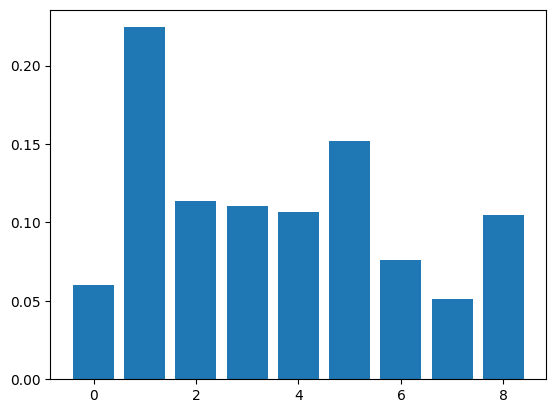

In [ ]:
import matplotlib.pyplot as plt

tictactoe = TicTacToe()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

state = tictactoe.get_initial_state()
state = tictactoe.get_next_state(state, 2, 1)
state = tictactoe.get_next_state(state, 7, -1)

print(state)

encoded_state = tictactoe.get_encoded_state(state)
print(encoded_state)

tensor_state = torch.tensor(encoded_state, device=device).unsqueeze(0)

model = ResNet(tictactoe, 4, 64, device=device)
model.load_state_dict(torch.load("model_2.pt", map_location=device))
model.eval()

policy, value = model(tensor_state)
value = value.item()
policy = torch.softmax(policy, axis=1).squeeze(0).detach().numpy()

print(value, policy)

plt.bar(range(tictactoe.action_size), policy)
plt.show()

Definition MCTS and Node

In [4]:
class Node:
    def __init__(self, game, args, state, parent=None, action_taken=None, prior=0, visit_count=0):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior

        self.children = []
        self.expandable_moves = game.get_valid_moves(state)

        self.visit_count = visit_count
        self.value_sum = 0

    def is_fully_expanded(self):
        return len(self.children) > 0
    
    def select(self):
        best_child = None
        best_ucb = -np.inf
        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb
        return best_child
    
    def get_ucb(self, child):
        if child.visit_count == 0:
            q_value = 0
        else:
            q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2
        return q_value + self.args['C'] * math.sqrt(self.visit_count / (child.visit_count + 1)) * child.prior
    
    def expand(self, policy):
        for action, prob in enumerate(policy):
            if prob > 0:
                child_state = self.state.copy()
                child_state = self.game.get_next_state(child_state, action, 1)
                child_state = self.game.change_perspective(child_state, player=-1)

                child = Node(self.game, self.args, child_state, self, action, prob)
                self.children.append(child)
        return child
    
    def backpropagate(self, value):
        self.value_sum += value
        self.visit_count += 1

        value = self.game.get_opponent_value(value)
        if self.parent is not None:
            self.parent.backpropagate(value)

class MCTS:
    def __init__(self, game, args, model):
        self.game = game
        self.args = args
        self.model = model
    
    @torch.no_grad()
    def search(self, state):
        root = Node(self.game, self.args, state, visit_count=1)

        policy, _ = self.model(
            torch.tensor(self.game.get_encoded_state(state), device=self.model.device).unsqueeze(0)
        )
        policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()

        policy = (1- self.args['dirichlet_epsiolon'] * policy + self.args['dirichlet_epsilon'] * np.random.dirichlet([self.args['dirichlet_alpha']] * self.game.action_size))

        valid_moves = self.game.get_valid_moves(state)
        policy *= valid_moves
        policy /= np.sum(policy)
        root.expand(policy)

        for search in range(self.args['num_searches']):
            node = root
            while node.is_fully_expanded():
                node = node.select()

            value, is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)
            value = self.game.get_opponent_value(value)

            if not is_terminal:
                policy, value = self.model(
                    torch.tensor(self.game.get_encoded_state(node.state), device=self.model.device).unsqueeze(0)
                )
                policy = torch.softmax(policy, axis=1).squeeze(0).numpy()
                valid_moves = self.game.get_valid_moves(node.state)
                policy *= valid_moves
                policy /= np.sum(policy)

                value = value.item()

                node = node.expand(policy)

            node.backpropagate(value)

        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        action_probs /= np.sum(action_probs)
        
        return action_probs


Definiton AlphaZero

In [8]:
class AlphaZero:
    def __init__(self, model, optimizer, game, args):
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        self.mcts = MCTS(game, args, model)
    
    def selfPlay(self):
        memory = []
        player = 1
        state = self.game.get_initial_state()
        
        while True:
            neutral_state = self.game.change_perspective(state, player)
            action_probs = self.mcts.search(neutral_state)

            memory.append((neutral_state, action_probs, player))

            temp_action_probs = action_probs ** (1 / self.args['temperature'])
            action = np.random.choice(self.game.action_size, p=temp_action_probs)

            state = self.game.get_next_state(state, action, player)

            value, is_terminal = self.game.get_value_and_terminated(state, action)

            if is_terminal:
                returnMemory = []
                for hist_neutra_state, hist_action_probs, hist_player in memory:
                    hist_outcome = value if hist_player == player else self.game.get_opponent_value(value)
                    returnMemory.append((
                        self.game.get_encoded_state(hist_neutra_state),
                        hist_action_probs,
                        hist_outcome
                    ))
                return returnMemory
            
            player = self.game.get_opponent(player)

    def train(self, memory):
        random.shuffle(memory)
        for batchIdx in range(0, len(memory), self.args['batch_size']):
            sample = memory[batchIdx:min(len(memory) - 1, batchIdx+self.args['batch_size'])]
            state, policy_targets, value_targets = zip(*sample)

            state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)

            state = torch.tensor(state, dtype=torch.float32, device=self.model.device)
            policy_targets = torch.tensor(policy_targets, dtyte=torch.float32, device=self.model.device)
            value_targets = torch.tensor(value_targets, dtype=torch.float32, device=self.model.device)

            out_policy, out_value = self.model(state)

            policy_loss = F.cross_entropy(out_policy, policy_targets)
            value_loss = F.mse_loss(out_value, value_targets)
            loss = policy_loss + value_loss

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

    def learn(self):
        for iteration in range(self.args['num_iterations']):
            memory = []
            
            self.model.eval()
            for SelPlay_iteration in range(self.args['num_selfPlay_iterations']):
                memory += self.selfPlay()

            self.model.train()
            for epoch in range(self.args['num_epochs']):
                self.train(memory)
            
            torch.save(self.model.state_dict(), f"model_{iteration}_{self.game}.pt")
            torch.save(self.optimizer.state_dict(), f"optimizer_{iteration}_{self.game}.pt")

In [ ]:
class MCTSParallel:
    def __init__(self, game, args, model):
        self.game = game
        self.args = args
        self.model = model
    
    @torch.no_grad()
    def search(self, states, spGames):
        policy, _ = self.model(
            torch.tensor(self.game.get_encoded_state(states), device=self.model.device)
        )
        policy = torch.softmax(policy, axis=1).cpu().numpy()

        policy = (1 - self.args['dirichlet_epsiolon'] * policy + self.args['dirichlet_epsilon'] * np.random.dirichlet([self.args['dirichlet_alpha']] \
                    * self.game.action_size, size=policy.shape[0]))

        for i, spg in enumerate(spGames):
            spg_poliy = policy[i]
            valid_moves = self.game.get_valid_moves(states[i])
            spg_policy *= valid_moves
            spg_policy /= np.sum(spg_policy)

            spg.root = Node(self.game, self.args, states[i], visit_count=1)
            spg.root.expand(spg_policy)

        for search in range(self.args['num_searches']):
            for spg in spGames:
                spg.node = None
                node = spg.root

                while node.is_fully_expanded():
                    node = node.select()

                value, is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)
                value = self.game.get_opponent_value(value)

                if is_terminal:
                    node.backpropagate(value)
                
                else:
                    spg.node = node

            expandable_spGames = [mappingIdx for mappingIdx in range(len(spGames)) if spGames[mappingIdx].node is not Node]

            if len(expandable_spGames) > 0:
                states = np.stack([spGames[mappingIdx].node.state for mappingIdx in expandable_spGames])

                policy, value = self.model(
                    torch.tensor(self.game.get_encoded_state(node.state), device=self.model.device)
                )
                policy = torch.softmax(policy, axis=1).numpy()

                for i, mappingIdx in enumerate(expandable_spGames):
                    node = spGames[mappingIdx].node
                    spg_policy, spg_value = policy[i], value[i]
                    valid_moves = self.game.get_valid_moves(node.state)
                    spg_policy *= valid_moves
                    spg_policypolicy /= np.sum(spg_policy)

                    node = node.expand(spg_policy)
                    node.backpropagate(value)

In [ ]:
class AlphaZeroParallel:
    def __init__(self, model, optimizer, game, args):
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        self.mcts = MCTSParallel(game, args, model)
    
    def selfPlay(self):
        return_memory = []
        player = 1
        spGames = [SPG(self.game) for spg in range(self.args['num_parallel_games'])]

        while len(spGames) > 0:
            states = np.stack([spg.state for spg in spGames])

            neutral_states = self.game.change_perspective(states, player)

            self.mcts.search(neutral_states, spGames)

            for i in range(len(spGames))[::-1]:
                spg = spGames[i]

                action_probs = np.zeros(self.game.action_size)
                for child in spg.root.children:
                    action_probs[child.action_taken] = child.visit_count
                action_probs /= np.sum(action_probs)
            
                spg.memory.append((spg.root.state, action_probs, player))

                temp_action_probs = action_probs ** (1 / self.args['temperature'])
                action = np.random.choice(self.game.action_size, p=temp_action_probs)

                spg.state = self.game.get_next_state(spg.state, action, player)

                value, is_terminal = self.game.get_value_and_terminated(spg.state, action)

                if is_terminal:
                    for hist_neutra_state, hist_action_probs, hist_player in spg.memory:
                        hist_outcome = value if hist_player == player else self.game.get_opponent_value(value)
                        return_memory.append((
                            self.game.get_encoded_state(hist_neutra_state),
                            hist_action_probs,
                            hist_outcome
                        ))
                    del spGames[i]
                
            player = self.game.get_opponent(player)
        
        return return_memory
            
    def train(self, memory):
        random.shuffle(memory)
        for batchIdx in range(0, len(memory), self.args['batch_size']):
            sample = memory[batchIdx:min(len(memory) - 1, batchIdx+self.args['batch_size'])]
            state, policy_targets, value_targets = zip(*sample)

            state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)

            state = torch.tensor(state, dtype=torch.float32, device=self.model.device)
            policy_targets = torch.tensor(policy_targets, dtyte=torch.float32, device=self.model.device)
            value_targets = torch.tensor(value_targets, dtype=torch.float32, device=self.model.device)

            out_policy, out_value = self.model(state)

            policy_loss = F.cross_entropy(out_policy, policy_targets)
            value_loss = F.mse_loss(out_value, value_targets)
            loss = policy_loss + value_loss

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

    def learn(self):
        for iteration in range(self.args['num_iterations']):
            memory = []
            
            self.model.eval()
            for SelPlay_iteration in range(self.args['num_selfPlay_iterations'] // self.args['num_parallel_games']):
                memory += self.selfPlay()

            self.model.train()
            for epoch in range(self.args['num_epochs']):
                self.train(memory)
            
            torch.save(self.model.state_dict(), f"model_{iteration}_{self.game}.pt")
            torch.save(self.optimizer.state_dict(), f"optimizer_{iteration}_{self.game}.pt")
    
class SPG:
    def __init__(self, game):
        self.state = game.get_initial_state()
        self.memory = []
        self.root = None
        self.node = None

TicTacToe Training

In [6]:
tictactoe = TicTacToe()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = ResNet(tictactoe, 4, 64, device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

args = {
    'C': 2,
    'num_searches': 60,
    'num_iterations': 3,
    'num_selfPlay_iterations': 500,
    'num_epochs': 4,
    'batch_size': 64,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3
}

alphaZero = AlphaZero(model, optimizer, tictactoe, args)
alphaZero.learn()

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


TypeError: tensor() got an unexpected keyword argument 'dyte'

TicTacToe (AlphaZero plays against you now)

In [ ]:
tictactoe = TicTacToe()
player = 1

args = {
    'C': 2,
    'num_searches': 1000
}

model = ResNet(tictactoe, 4, 64)
model.eval()

mcts = MCTS(tictactoe, args, model)

state = tictactoe.get_initial_state()

while True:
    print(state)

    if player == 1:
        valid_moves = tictactoe.get_valid_moves(state)
        print("valid moves:", [i for i in range(tictactoe.action_size) if valid_moves[i] == 1])
        action = int(input(f"{player}:"))

        if valid_moves[action] == 0:
            print("action not valid")
            continue

    else:
        neutral_state = tictactoe.change_perspective(state, player)
        mcts_probs = mcts.search(neutral_state)
        action = np.argmax(mcts_probs)

    state = tictactoe.get_next_state(state, action, player)

    value, is_terminal = tictactoe.get_value_and_terminated(state, action)

    if is_terminal:
        print(state)
        if value == 1:
            print(player, "won")
        else:
            print("draw")
        break

    player = tictactoe.get_opponent(player)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
valid moves: [0, 1, 2, 3, 4, 5, 6, 7, 8]
[[0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[ 0.  1. -1.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
valid moves: [0, 3, 4, 5, 6, 7, 8]
[[ 0.  1. -1.]
 [ 1.  0.  0.]
 [ 0.  0.  0.]]
[[ 0.  1. -1.]
 [ 1.  0.  0.]
 [ 0.  0. -1.]]
valid moves: [0, 4, 5, 6, 7]
[[ 0.  1. -1.]
 [ 1.  1.  0.]
 [ 0.  0. -1.]]
[[ 0.  1. -1.]
 [ 1.  1. -1.]
 [ 0.  0. -1.]]
-1 won


Definition ConnectFour


In [ ]:

class ConnectFour:
    def __init__(self):
        self.height = 6
        self.width = 7
        self.action_size = self.width
        self.in_a_row = 4

    def __repr__(self):
        return "ConnectFour"
    
    def get_initial_state(self):
        return np.zeros((self.height, self.width))

    def get_next_state(self, state, action, player):
        row = np.max(np.where(state[:, action] == 0))
        state[row, action] = player
        return state
    
    def get_valid_moves(self, state):
        return (state[0] == 0).astype(np.uint8)
    
    def check_win(self, state, action):
        if action == None:
            return False

        row = np.min(np.where(state[:, action] != 0))
        column = action
        player = state[row][column]

        def count(offset_row, offset_column):
            for i in range(1, self.in_a_row):
                r = row + offset_row * i
                c = action + offset_column * i
                if (
                    r < 0
                    or r >= self.height
                    or c < 0
                    or c >= self.width
                    or state[r][c] != player
                ):
                    return i - 1
            return self.in_a_row - 1
        
        return (
            count (1, 0) >= self.in_a_row - 1
            or (count(0, 1) + count(0, -1)) >= self.in_a_row - 1
            or (count(1, 1) + count(-1, -1)) >= self.in_a_row - 1
            or (count(1, -1) + count(-1, 1)) >= self.in_a_row - 1
        )
    
    def get_value_and_terminated(self, state, action):
        if self.check_win(state, action):
            return 1, True
        if np.sum(self.get_valid_moves(state)) == 0:
            return 0, True
        return 0, False
    
    def get_opponent(self, player):
        return -player
    
    def get_opponent_value(self, value):
        return -value
    
    def change_perspective(self, state, player):
        return state * player
    
    def get_encoded_state(self, state):
        encoded_state = np.stack(
            (state == -1, state==0, state==1)
        ).astype(np.float32)

        if len(state.shape) == 3:
            encoded_state = np.swapaxes(encoded_state, 0 , 1)

        return encoded_state

ConnectFour Training

In [10]:
game = ConnectFour()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = ResNet(game, 9, 128, device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

args = {
    'C': 2,
    'num_searches': 600,
    'num_iterations': 8,
    'num_selfPlay_iterations': 500,
    'num_parallel_games': 100,
    'num_epochs': 4,
    'batch_size': 128,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3
}

alphaZero = AlphaZero(model, optimizer, game, args)
alphaZero.learn()

ValueError: probabilities do not sum to 1

Test ConnectFour (plays against you)

In [9]:
game = ConnectFour()
player = 1

args = {
    'C': 2,
    'num_searches': 100
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet(game, 9, 128, device)
model.eval()

mcts = MCTS(game, args, model)

state = game.get_initial_state()

while True:
    print(state)

    if player == 1:
        valid_moves = game.get_valid_moves(state)
        print("valid moves:", [i for i in range(game.action_size) if valid_moves[i] == 1])
        action = int(input(f"{player}:"))

        if valid_moves[action] == 0:
            print("action not valid")
            continue

    else:
        neutral_state = game.change_perspective(state, player)
        mcts_probs = mcts.search(neutral_state)
        action = np.argmax(mcts_probs)

    state = game.get_next_state(state, action, player)

    value, is_terminal = game.get_value_and_terminated(state, action)

    if is_terminal:
        print(state)
        if value == 1:
            print(player, "won")
        else:
            print("draw")
        break

    player = game.get_opponent(player)

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
valid moves: [0, 1, 2, 3, 4, 5, 6]
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  1.  0.]]
valid moves: [0, 1, 2, 3, 4, 5, 6]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  1.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.]
 [-1.  0. -1.  0.  0.  1.  0.]]
valid moves: [0, 1, 2, 3, 4, 5, 6]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.

ValueError: invalid literal for int() with base 10: ''